# SMC samplers
SMC samplers are SMC algorithms that sample from a sequence of target distributions. In this tutorial, these target distributions will be Bayesian posterior distributions of static models.

## Defining a static model

A static model is a Python object that represents a Bayesian model with fixed parameter $\theta$. One may define a static model by subclassing `StateSpaceModel`, and defining method `logpyt`, which evaluates the log-likelihood of datapoint $Y_t$ (given $\theta$ and past datapoints $Y_{0:t-1}$). Here is a simple example: 

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sb
from scipy import stats

import pysqmc
from pysqmc import smc_samplers as ssp
from pysqmc import distributions as dists

class ToyModel(ssp.StaticModel):
    def logpyt(self, theta, t):  # density of Y_t given theta and Y_{0:t-1}
        return stats.norm.logpdf(self.data[t], loc=theta['mu'],
                                 scale = theta['sigma'])

In words, we are considering a model where the observations $Y_t$ are IID, with distribution $N(\mu, \sigma^2)$. The parameter is $\theta=(\mu, \sigma)$.

Class `ToyModel` contains information about the likelihood of the considered model, but not about its prior, or the considered data. To specify those, we instantiate `ToyModel` as follows: 


In [2]:
T = 1000
my_data = stats.norm.rvs(loc=3.14, size=T)
my_prior = dists.StructDist({'mu': dists.Normal(scale=10.),
                             'sigma': dists.Gamma()})
my_static_model = ToyModel(data=my_data, prior=my_prior)

This time, object `my_static_model` has enough information to define the posterior distribution(s) of the model (given all data, or part of the data). In fact, it inherits from `StaticModel` method `logpost`, which evaluates (for a collection of $\theta$ values) the posterior log-density at any time $t$ (meaning given data $y_{0:t}$). 

In [3]:
thetas = my_prior.rvs(size=5) 
my_static_model.logpost(thetas, t=5)  # if t is omitted, gives the full posterior

array([-1.36905860e+01, -9.85642677e+01, -5.59767407e+01, -2.03317792e+04,
       -6.65700351e+01])

The input of `logpost` (and output of `myprior.rvs()`) is a [structured array](https://docs.scipy.org/doc/numpy/user/basics.rec.html), with the same keys as the prior distribution:

In [4]:
thetas['mu'][0]

3.5123772107511964

Typically, you won't need to call `logpost` yourself, this will be done by the SMC sampler for you. 

## IBIS
The IBIS (iterated batch importance sampling) algorithm is a SMC sampler that samples iteratively from a sequence of posterior distributions, 
$p(\theta|y_{0:t})$, for $t=0,1,\ldots$. 

Module `smc_samplers` defines `IBIS` as a subclass of `FeynmanKac`. 

In [5]:
my_ibis = ssp.IBIS(my_static_model)
my_alg = pysqmc.SMC(fk=my_ibis, N=1000, store_history=True)
my_alg.run()

/home/manxac/Dropbox/rech/projects/pysqmc/pysqmc/smc_samplers.py:405: RuntimeWarning: invalid value encountered in less
  accept = (np.log(stats.uniform.rvs(size=self.N)) < lp_acc)


Since we set `store_history` to `True`, the particles and their weights have been saved at every time (in attribute `hist`, see previous tutorials on smoothing). Let's plot the posterior distributions of $\mu$ and $\sigma$ at various times.

/home/manxac/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/manxac/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


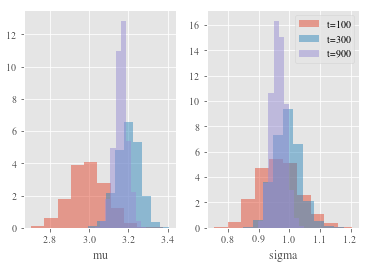

In [6]:
plt.style.use('ggplot')
for i, p in enumerate(['mu', 'sigma']):
    plt.subplot(1, 2, i + 1)
    for t in [100, 300, 900]:
        plt.hist(my_alg.hist.X[t].theta[p], weights=my_alg.hist.wgt[t].W, label="t=%i" % t, alpha=0.5, density=True)
    plt.xlabel(p)
plt.legend()

As expected, the posterior distribution concentrates progressively around the true values. 

As before, once the algorithm is run, `my_smc.X` contains the N final particles. However, object `my_smc.X` is no longer a simple (N,) or (N,d) numpy array. It is a `ThetaParticles` object, with attributes:
* theta: a structured array: as mentioned above, this is an array with ; i.e. my_smc.X.theta['mu'] be
* `lpost`: a (N,) numpy array that contains the target (posterior) log-density of each of the N particles
* `acc_rates`: a list of the acceptance rates of the resample-move steps

['26.52%', '19.93%', '23.29%', '29.52%', '30.54%', '31.80%', '32.42%', '32.62%', '36.36%', '34.90%', '35.45%', '35.88%', '36.68%']


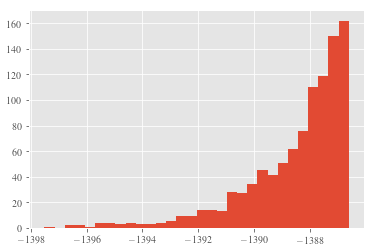

In [7]:
print(["%2.2f%%" % (100 * np.mean(r)) for r in my_alg.X.acc_rates])
plt.hist(my_alg.X.lpost, 30);

Unless you want to implement your own SMC samplers, you do not need to know much more about what is exactly is a `ThetaParticles` object. However it is worth mentioning that class `SMC` does not require a specific type (e.g. a numpy array) to represent a collection of N particles.

## Regarding the Metropolis steps

As the text output of `my_alg.run()` suggests, the algorithm "resample-moves" whenever the ESS is below a certain threshold ($N/2$ by default). When this occurs, particles are resampled, and then moved through a certain number of Metropolis-Hastings steps. By default, the proposal is a Gaussian random walk, and both the number of steps and the covariance matrix of the random walk are chosen automatically as follows:
 
* the covariance matrix of the random walk is set to `scale` times   the empirical (weighted) covariance matrix of the particles. The default value for `scale` is $2.38 / \sqrt{d}$, where $d$ is the dimension of $\theta$. 
* the algorithm performs Metropolis steps until the relative increase of the  average distance between the starting point and the end point is below a certain threshold $\delta$. 

Class `IBIS` takes as an optional argument `mh_options`, a dictionary which may contain the following (key, values) pairs: 
* `'type_prop'`: either `'random walk'` or `'independent`'; in the latter case, an independent Gaussian proposal is used. The mean of the Gaussian is set to the weighted mean of the particle. Same thing for the variance, except that it is inflated by factor `scale`. 
* `'scale`': determines the scale of the proposal. 
* `'nsteps'`: number of steps. If set to `0`, the adaptive strategy described above is used. 

Let's illustrate all this by calling IBIS again: 

In [8]:
alt_ibis = ssp.IBIS(my_static_model, mh_options={'type_prop': 'independent', 
                                                 'nsteps': 10})
alt_alg = pysqmc.SMC(fk=alt_ibis, N=1000, ESSrmin=0.2)
alt_alg.run()

/home/manxac/Dropbox/rech/projects/pysqmc/pysqmc/smc_samplers.py:405: RuntimeWarning: invalid value encountered in less
  accept = (np.log(stats.uniform.rvs(size=self.N)) < lp_acc)


Well, apparently the algorithm did what we asked. We have also changed the threshold of 
 Let's see how the ESS evolved:

Text(0, 0.5, 'ESS')

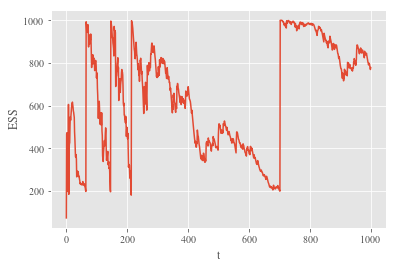

In [9]:
plt.plot(alt_alg.summaries.ESSs)
plt.xlabel('t')
plt.ylabel('ESS')

As expected, the algorithm waits until the ESS is below 200 to trigger a resample-move step.

## SMC tempering
SMC tempering is a SMC sampler that samples iteratively from the following sequence of distributions: 
$$\pi_t(\theta) \propto \pi(\theta) L(\theta)^\gamma_t$$
with $0=\gamma_0 < \ldots < \gamma_T = 1$. In words, this sequence is a **geometric bridge**, which interpolates between the prior and the posterior. 

SMC tempering implemented in the same was as IBIS: as a sub-class of `FeynmanKac`, whose `__init__` function takes as argument a `StaticModel` object. 

In [10]:
fk_tempering = ssp.AdaptiveTempering(my_static_model)
my_temp_alg = pysqmc.SMC(fk=fk_tempering, N=1000, ESSrmin=1.)
my_temp_alg.run()

/home/manxac/Dropbox/rech/projects/pysqmc/pysqmc/smc_samplers.py:405: RuntimeWarning: invalid value encountered in less
  accept = (np.log(stats.uniform.rvs(size=self.N)) < lp_acc)


**Note**: Recall that `SMC` resamples every time the ESS drops below value N times option `ESSrmin`; here we set it to to 1, since we want to resample at every time. This makes sense: Adaptive SMC chooses adaptively the successive values of $\gamma_t$ so that the ESS drops to $N/2$ (by default). 

We have not saved the intermediate results this time (option `store_history` was not set) since they are not particularly interesting. Let's look at the final results: 

/home/manxac/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


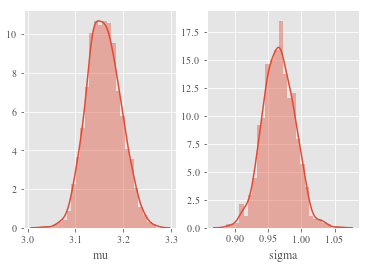

In [11]:
for i, p in enumerate(['mu', 'sigma']):
    plt.subplot(1, 2, i + 1)
    sb.distplot(my_temp_alg.X.theta[p])
    plt.xlabel(p)

This looks reasonable!
You can see from the output that the algorithm automatically chooses the tempering exponents $\gamma_1, \gamma_2,\ldots$. In fact, at iteration $t$, the next value for $\gamma$ is set that the ESS drops at most to $N/2$. You can change this particular threshold by passing argument ESSrmin to TemperingSMC. (Warning: do not mistake this with the `ESSrmin` argument of class `SMC`):

In [12]:
lazy_tempering = ssp.AdaptiveTempering(my_static_model, ESSrmin = 0.1)
lazy_alg = pysqmc.SMC(fk=lazy_tempering, N=1000)
lazy_alg.run()

/home/manxac/Dropbox/rech/projects/pysqmc/pysqmc/smc_samplers.py:405: RuntimeWarning: invalid value encountered in less
  accept = (np.log(stats.uniform.rvs(size=self.N)) < lp_acc)


The algorithm progresses faster this time, but the ESS drops more between each step.
Another optional argument for Class `TemperingSMC` is `options_mh`, which works exactly as for `IBIS`, see above. That is, by default, the particles are moved according to a certain (adaptative) number of random walk steps, with a variance calibrated to the particle variance.